# Churn Prediction - Telecom Case
Author: Daniel Grzebyk

Date: 1.07.2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif, SelectFromModel, RFE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score

from classification_utils import chi_test, chi_test_new, find_boolean_features, find_correlated_features, remove_outliers

from functools import partial
from sklearn.feature_selection import mutual_info_classif, SelectKBest

## Loading the data

In [2]:
df = pd.read_csv("data/telecom/data.csv")
var_df = pd.read_csv("data/telecom/variables-definition.csv")

In [3]:
# Droping biased or unnecessary features
df.drop(columns=['ethnic', 'Customer_ID'], inplace=True)

In [4]:
X = df.drop(columns=['churn']).copy()
y = df['churn'].copy()

In [5]:
X.shape

(100000, 97)

### Investigating Correlations
1. Removing features correlated with other features
2. Removing features uncorrelated with churn (label)

#### Categorical Features

In [30]:
cat_features = X.select_dtypes(include='object').columns

my_x = X[cat_features].dropna().copy()
my_y = y.loc[my_x.index]

one_hot = OneHotEncoder(sparse=False)  # handle_unknown='ignore'
my_x_enc = one_hot.fit_transform(my_x)

chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(my_x_enc, my_y)

X_train_chi = chi2_selector.transform(my_x_enc)

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [60]:
feature_names = one_hot.get_feature_names(cat_features)

chi_df = pd.DataFrame({"feature": feature_names, "score": chi2_selector.scores_, "p_value": chi2_selector.pvalues_})
chi_df.loc[chi_df['p_value'] < 0.05].sort_values(by='p_value').head()

,feature,score,p_value
85,hnd_webcap_WC,152.207486,5.707930e-35
55,asl_flag_Y,69.219212,8.810560e-17
80,dualband_N,48.087422,4.076330e-12
91,marital_U,44.033145,3.228621e-11
84,refurb_new_R,38.982492,4.276233e-10


<AxesSubplot:xlabel='feature'>

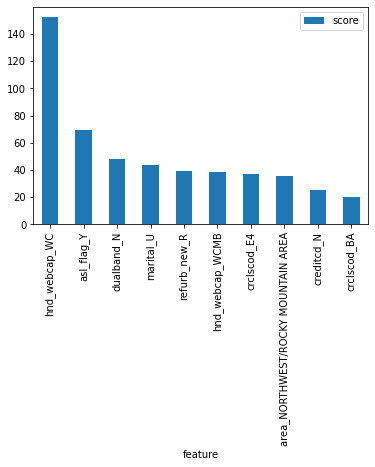

In [66]:
chi_df.nsmallest(10, columns=['p_value']).plot(x='feature', y='score', kind='bar')

#### Numerical features
Continous numerical features are also investigated looking for correlations.

['mou_Mean', 'totmrc_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'change_rev', 'drop_vce_Mean', 'unan_vce_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callwait_Mean', 'actvsubs', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'phones', 'models', 'rv']

 (100000, 43)


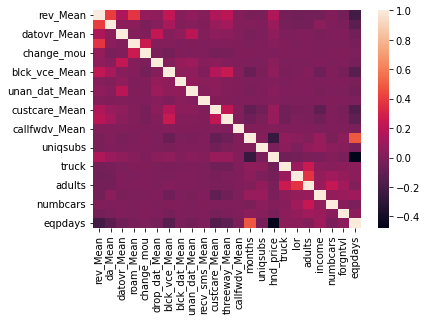

In [9]:
num_features = X.select_dtypes(include='number').columns
correlated_features = find_correlated_features(X[num_features], threshold=0.5)
print(correlated_features)

# Drop correlated features 
X.drop(columns=correlated_features, axis=1, inplace=True)
num_features = X.select_dtypes(include='number').columns

sns.heatmap(X[num_features].corr())
print('\n', X.shape)

## Data Preprocessing
### Removing duplicates

In [10]:
X.duplicated().sum()

0

### Removing outliers

In [11]:
def remove_outliers_iqr(X, cols):
    for col in cols:
        feature = X[col]
        q1 = feature.quantile(0.25)
        q3 = feature.quantile(0.75)
        iqr = q3 - q1
        mask = feature.loc[((feature < (q1 - 1.5 * iqr)) | (feature > (q3 + 1.5 * iqr)))].index
        X.loc[mask, col] = np.nan
    return X

In [12]:
num_features = X.select_dtypes(include='number').columns
X = remove_outliers_iqr(X, num_features)

### Removing NaNs
Some columns have so many missing values that keeping them would leave us with too small dataset. Therefore, firstly entire columns with too many missing values are removed and then NaNs are dropped per row. 

In [13]:
# Count NaNs
nans_per_feature = X.isna().sum()
nans_per_feature[nans_per_feature > 10000].sort_values(ascending=False)  # Is one of the dropped features crucial?

numbcars         49366
dwllsize         38308
HHstatin         37923
ownrent          33706
dwlltype         31909
lor              30190
income           25436
adults           23019
infobase         22079
truck            20287
roam_Mean        19271
change_mou       14381
datovr_Mean      14030
custcare_Mean    12710
da_Mean          11025
blck_vce_Mean    10701
hnd_webcap       10189
dtype: int64

In [14]:
cols_to_drop = list(nans_per_feature[nans_per_feature > 10000].index)  # drop features which have more than 20% NaNs
X.drop(columns=cols_to_drop, inplace=True)
print("Dropping:", cols_to_drop)

print("Before dropping rows with NaNs:", X.shape)
X.dropna(inplace=True)
y = y.loc[X.index]
print("After dropping rows with NaNs:", X.shape)

Dropping: ['truck', 'ownrent', 'lor', 'dwlltype', 'adults', 'infobase', 'income', 'numbcars', 'HHstatin', 'dwllsize']
Before dropping rows with NaNs: (100000, 33)
After dropping rows with NaNs: (31490, 33)


### Looking for class imbalance

In [15]:
y.value_counts()

0    16053
1    15437
Name: churn, dtype: int64

In [16]:
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns
len(num_features), len(cat_features)

(18, 15)

## Predicting churn

### Splitting the data

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape

(25192, 33)

### Feature Selection

In [19]:
%%time
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), 
           ("var_thr", VarianceThreshold(threshold=0.1))]
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder()), 
           ("chi_selector",  SelectKBest(chi2, k=10))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder = 'passthrough',
    n_jobs=-1
)

selector = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("ref", RFE(RandomForestClassifier(n_jobs=-1), 
                       n_features_to_select=10, 
                       step=1))]
)

selector.fit(X_train, y_train)

Wall time: 13.9 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('var_thr',
                                                                   VarianceThreshold(threshold=0.1))]),
                                                  Index(['rev_Mean', 'da_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'unan_dat_Mean',
       'recv_sms_Mean', 'custca...
                                                                  ('chi_selector',
                                                                   SelectKBest(score_func=<function chi2 at 0x000002C47896A3A0>))]),
                                              

In [20]:
# Train Inference
y_pred = selector.predict(X_train)
y_val_pred = selector.predict(X_val)

In [21]:
# Train metric
train_acc = accuracy_score(y_train, y_pred)
train_prec = precision_score(y_train, y_pred)
train_recall = recall_score(y_train, y_pred)
print("Train Accuracy:", train_acc.round(2))
print("Train Precision:", train_prec.round(2))
print("Train Recall:", train_recall.round(2))

# Val metric
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
print("\nValidation Accuracy:", val_acc.round(2))
print("Validation Precision:", val_prec.round(2))
print("Validation Recall:", val_recall.round(2))

Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0

Validation Accuracy: 0.58
Validation Precision: 0.57
Validation Recall: 0.57


In [22]:
# selector.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].categories_

In [23]:
# selector.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].drop_idx_

In [24]:
# selector[1].support_

### Training the model

In [25]:
%%time
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), 
           ("var_thr", VarianceThreshold(threshold=0.1))],
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder()), # handle_unknown="ignore"
           ("cat_selector",  SelectKBest(chi2, k=10))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder = 'passthrough',
    n_jobs=-1
)

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", RandomForestClassifier(n_jobs=-1, max_depth=20, max_features=10, min_samples_leaf=2))]
)
#   LogisticRegression(n_jobs=-1, max_iter=10000, C=0.1, warm_start=True)

pipeline.fit(X_train, y_train)
print("model score: %.3f" % pipeline.score(X_val, y_val))

model score: 0.585
Wall time: 2.88 s


### Inference

In [26]:
# Train Inference
y_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)

### Evaluation

In [27]:
# Train metric
train_acc = accuracy_score(y_train, y_pred)
train_prec = precision_score(y_train, y_pred)
train_recall = recall_score(y_train, y_pred)
print("Train Accuracy:", train_acc.round(2))
print("Train Precision:", train_prec.round(2))
print("Train Recall:", train_recall.round(2))

# Val metric
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
print("\nValidation Accuracy:", val_acc.round(2))
print("Validation Precision:", val_prec.round(2))
print("Validation Recall:", val_recall.round(2))

Train Accuracy: 0.97
Train Precision: 0.98
Train Recall: 0.96

Validation Accuracy: 0.59
Validation Precision: 0.57
Validation Recall: 0.59


## Error Analysis / Postprocessing

In [68]:
# feature_names = X_train.columns
# feature_importances = pipeline.steps[1][1].feature_importances_

# importance_df = pd.DataFrame({"name":feature_names, "importance":feature_importances})
# importance_df = importance_df.sort_values(by='importance', ascending=False)
# importance_df.plot(kind='bar', x='name')
# plt.show()